# Detecting volcanos on Venus from satellite imagery 

In [1]:
# Import libraries
import project_utils as prj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

# fix dimension ordering issue
from keras import backend as K
K.set_image_dim_ordering('th')

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
seed = 28

# Seaborn settings
sns.set_palette(palette="muted")
sns.set_style(style="white")

Using TensorFlow backend.


## Load, review, and summarize data
### Load data

In [2]:
# Load datasets
#data_train_imgs = pd.read_csv("data/train_images.csv", header=None)
#data_train_labels = pd.read_csv("data/train_labels.csv")
#data_test_imgs = pd.read_csv("data/test_images.csv", header=None)
#data_test_labels = pd.read_csv("data/test_labels.csv")

# Load datasets - Floydhub
data_train_imgs = pd.read_csv("/floyd/input/volcanoes_venus/train_images.csv", header=None)
data_train_labels = pd.read_csv("/floyd/input/volcanoes_venus/train_labels.csv")
data_test_imgs = pd.read_csv("/floyd/input/volcanoes_venus/test_images.csv", header=None)
data_test_labels = pd.read_csv("/floyd/input/volcanoes_venus/test_labels.csv")

### Describe data
#### View data

In [3]:
# Head of training images data
data_train_imgs.head(n=5)

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115


In [4]:
# Head of training labels
data_test_labels.head(n=5)

,Volcano?,Type,Radius,Number Volcanoes
0,0,NaN,NaN,NaN
1,0,NaN,NaN,NaN
2,1,1.0,17.00,1.0
3,0,NaN,NaN,NaN
4,1,3.0,15.13,1.0


#### Data shape

In [5]:
# Print summary of data shape
print("Train images data: Rows: {}, Columns: {}".format(data_train_imgs.shape[0], data_train_imgs.shape[1]))
print("Train labels data: Rows: {}, Columns: {}".format(data_train_labels.shape[0], data_train_labels.shape[1]))
print("Test images data: Rows: {}, Columns: {}".format(data_test_imgs.shape[0], data_test_imgs.shape[1]))
print("Test labels data: Rows: {}, Columns: {}".format(data_test_labels.shape[0], data_test_labels.shape[1]))

Train images data: Rows: 7000, Columns: 12100
Train labels data: Rows: 7000, Columns: 4
Test images data: Rows: 2734, Columns: 12100
Test labels data: Rows: 2734, Columns: 4


#### Data types/structure

In [6]:
# Data info/types of training images
data_train_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Columns: 12100 entries, 0 to 12099
dtypes: int64(12100)
memory usage: 646.2 MB


In [7]:
# Data info/types of testing images
data_test_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Columns: 12100 entries, 0 to 12099
dtypes: int64(12100)
memory usage: 252.4 MB


In [8]:
# Data info/types of training labels
data_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
Volcano?            7000 non-null int64
Type                1000 non-null float64
Radius              1000 non-null float64
Number Volcanoes    1000 non-null float64
dtypes: float64(3), int64(1)
memory usage: 218.8 KB


In [9]:
# Data info/types of training labels
data_test_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Data columns (total 4 columns):
Volcano?            2734 non-null int64
Type                434 non-null float64
Radius              434 non-null float64
Number Volcanoes    434 non-null float64
dtypes: float64(3), int64(1)
memory usage: 85.5 KB


#### Missing values

In [10]:
# Missing values in training images
np.sum(data_train_imgs.isna().sum())

0

In [11]:
# Missing values in test images
np.sum(data_test_imgs.isna().sum())

0

In [12]:
# Missing values in training labels
data_train_labels.isna().sum()

Volcano?               0
Type                6000
Radius              6000
Number Volcanoes    6000
dtype: int64

In [13]:
# Missing values in test labels
data_test_labels.isna().sum()

Volcano?               0
Type                2300
Radius              2300
Number Volcanoes    2300
dtype: int64

#### Class distribution

In [14]:
# Class distribution in training data
class_distribution_train = data_train_labels.groupby("Volcano?").size()
print(class_distribution_train)

print()
print("Class 0:", class_distribution_train[0] / np.sum(class_distribution_train))
print("Class 1:", class_distribution_train[1] / np.sum(class_distribution_train))

Volcano?
0    6000
1    1000
dtype: int64

Class 0: 0.8571428571428571
Class 1: 0.14285714285714285


In [15]:
# Class distribution in test data
class_distribution_test = data_test_labels.groupby("Volcano?").size()
print(class_distribution_test)

print()
print("Class 0:", class_distribution_test[0] / np.sum(class_distribution_test))
print("Class 1:", class_distribution_test[1] / np.sum(class_distribution_test))

Volcano?
0    2300
1     434
dtype: int64

Class 0: 0.8412582297000731
Class 1: 0.15874177029992684


#### Descriptive statistics

In [16]:
# Perhaps more useful for this data than describe()
flat_train_imgs = data_train_imgs.values.flatten()
flat_test_imgs = data_test_imgs.values.flatten()

print("Train images data:\nMin: {}\nMax: {}".format(np.min(flat_train_imgs), np.max(np.max(flat_train_imgs))))
print("\nTest images data:\nMin: {}\nMax: {}".format(np.min(flat_test_imgs), np.max(np.max(flat_test_imgs))))

Train images data:
Min: 0
Max: 234

Test images data:
Min: 0
Max: 234


In [17]:
# Describe train labels 
data_train_labels.describe()

,Volcano?,Type,Radius,Number Volcanoes
count,7000.000000,1000.000000,1000.000000,1000.000000
mean,0.142857,2.965000,16.257650,1.236000
std,0.349952,0.984248,11.632887,0.553724
min,0.000000,1.000000,1.000000,1.000000
25%,0.000000,2.000000,5.830000,1.000000
50%,0.000000,3.000000,14.870000,1.000000
75%,0.000000,4.000000,23.555001,1.000000
max,1.000000,4.000000,87.660000,5.000000


In [18]:
# Describe test labels 
data_test_labels.describe()

,Volcano?,Type,Radius,Number Volcanoes
count,2734.000000,434.000000,434.000000,434.000000
mean,0.158742,3.011521,15.444977,1.200461
std,0.365502,0.950194,11.144196,0.464837
min,0.000000,1.000000,2.000000,1.000000
25%,0.000000,2.000000,5.660000,1.000000
50%,0.000000,3.000000,13.745000,1.000000
75%,0.000000,4.000000,22.442500,1.000000
max,1.000000,4.000000,80.280000,3.000000


### Data visualizations
#### Display a selection of images

##### Images with volcanos

Volcano examples:


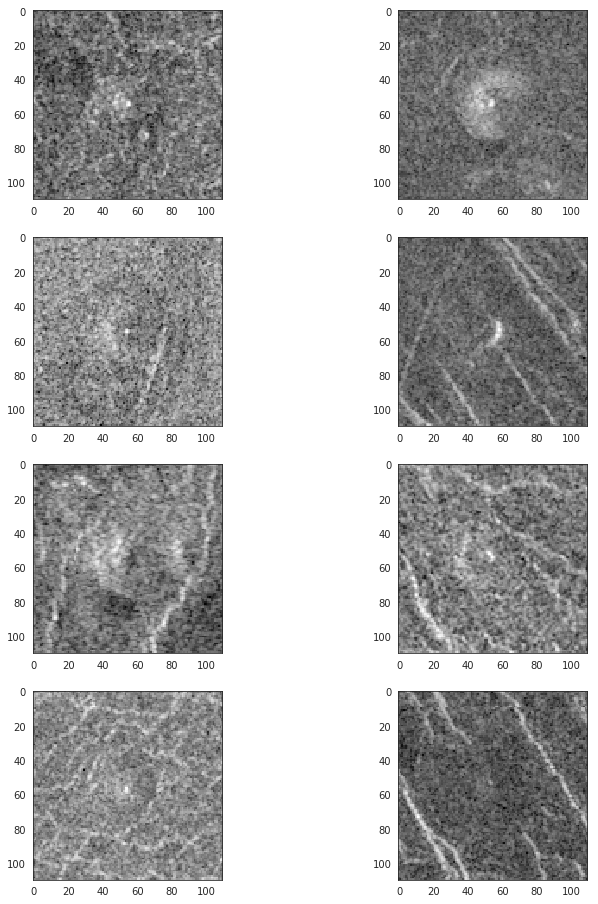

In [19]:
volcanos = data_train_labels[data_train_labels["Volcano?"] == 1].head(n=8).index

print("Volcano examples:")
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(12, 16)
axes[0,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[0]]), cmap="gray")
axes[0,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[1]]), cmap="gray")
axes[1,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[2]]), cmap="gray")
axes[1,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[3]]), cmap="gray")
axes[2,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[4]]), cmap="gray")
axes[2,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[5]]), cmap="gray")
axes[3,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[6]]), cmap="gray")
axes[3,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[volcanos[7]]), cmap="gray")
plt.show()

##### Images without volcanos

No volcano examples:


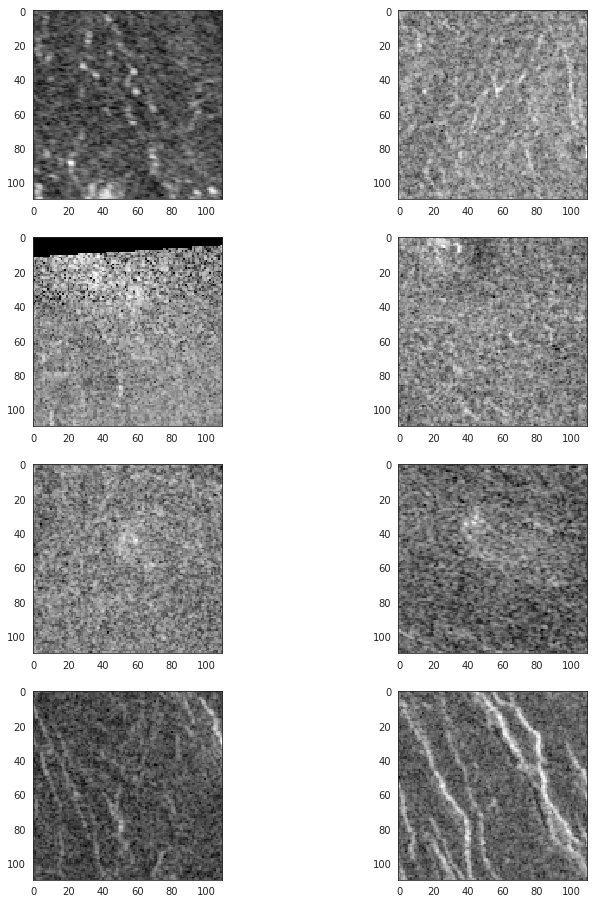

In [20]:
no_volcanos = data_train_labels[data_train_labels["Volcano?"] == 0].head(n=8).index

print("No volcano examples:")
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(12, 16)
axes[0,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[0]]), cmap="gray")
axes[0,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[1]]), cmap="gray")
axes[1,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[2]]), cmap="gray")
axes[1,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[3]]), cmap="gray")
axes[2,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[4]]), cmap="gray")
axes[2,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[5]]), cmap="gray")
axes[3,0].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[6]]), cmap="gray")
axes[3,1].imshow(prj.make_pic_mat(data_train_imgs.iloc[no_volcanos[7]]), cmap="gray")
plt.show()

#### Categorical bivarate plots

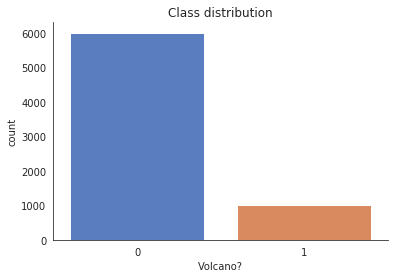

In [21]:
ax = sns.countplot(x="Volcano?", data=data_train_labels)
ax.set_title("Class distribution")
sns.despine()
plt.show()

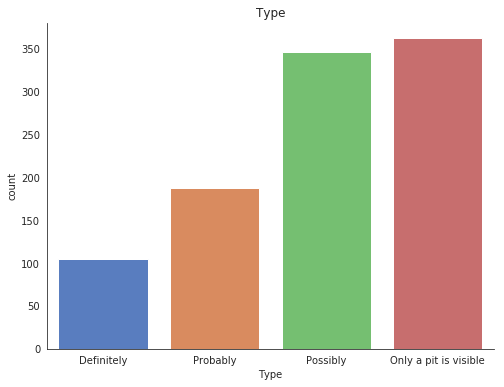

In [22]:
names = ["Definitely", "Probably", "Possibly", "Only a pit is visible"]
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Type", data=data_train_labels)
ax.set_title("Type")
ax.set_xticklabels(names)
sns.despine()
plt.show()

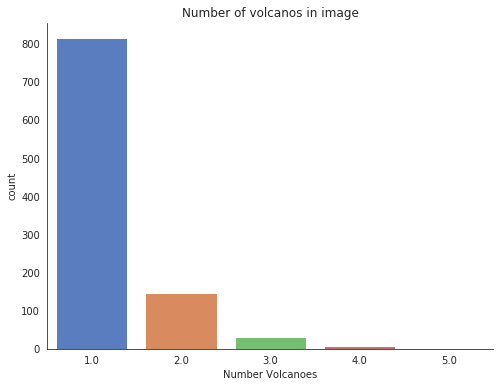

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Number Volcanoes", data=data_train_labels)
ax.set_title("Number of volcanos in image")
sns.despine()
plt.show()

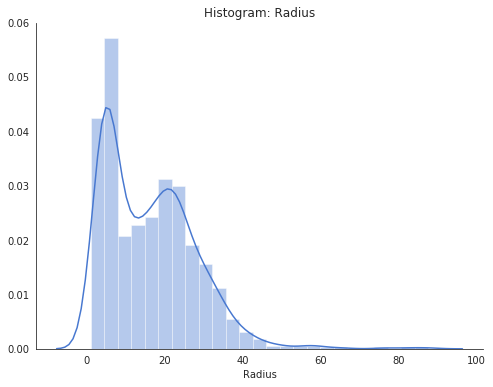

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = sns.distplot(a=data_train_labels["Radius"].dropna())
ax.set_title("Histogram: Radius")
sns.despine()
plt.show()

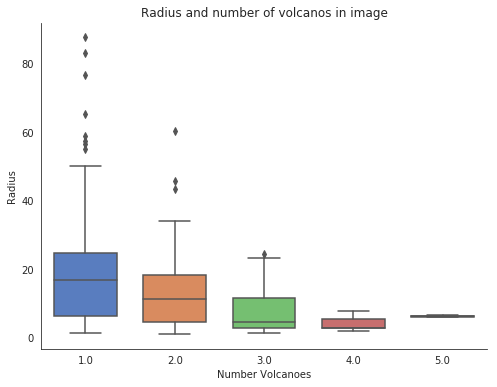

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Number Volcanoes", y="Radius", data=data_train_labels, width=0.7)
ax.set_title("Radius and number of volcanos in image")
sns.despine()
plt.show()

## Data preparation for modeling
### Select data for modeling and reformat to numerical arrays

In [26]:
# Create numpy arrays for train and test sets
X_train = data_train_imgs.values
X_test = data_test_imgs.values
y_train = data_train_labels["Volcano?"].values
y_test = data_test_labels["Volcano?"].values

print("Train images data: Rows: {}, Columns: {}".format(X_train.shape[0], X_train.shape[1]))
print("Train labels data: Rows: {}".format(y_train.shape[0]))
print("Test images data: Rows: {}, Columns: {}".format(X_test.shape[0], X_test.shape[1]))
print("Test labels data: Rows: {}".format(y_test.shape[0]))

Train images data: Rows: 7000, Columns: 12100
Train labels data: Rows: 7000
Test images data: Rows: 2734, Columns: 12100
Test labels data: Rows: 2734


### Normalize data

In [27]:
# Normalize data
X_train = X_train / 255
X_test = X_test / 255

### Upsample to balance class distribution

In [28]:
# Up-sample to balance target class
X_upsampled, y_upsampled = resample(X_train[y_train == 1], y_train[y_train == 1], replace=True,
                                   n_samples=X_train[y_train == 0].shape[0], random_state=seed)

X_train_up = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_up = np.hstack((y_train[y_train == 0], y_upsampled))

y_pred = np.zeros(y_train_up.shape[0])
print("New class distribution:", np.mean(y_pred == y_train_up))

print("X_train_up shape:", X_train_up.shape)
print("y_train_up shape:", y_train_up.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

New class distribution: 0.5
X_train_up shape: (12000, 12100)
y_train_up shape: (12000,)
X_test shape: (2734, 12100)
y_test shape: (2734,)


## Evaluate algorithms
### Machine learning algorithms

In [29]:
# Set test options and evaluation metric
num_folds = 10
scoring = "accuracy"

In [30]:
models = []
models.append(("lgr", LogisticRegression()))
models.append(("lda", LinearDiscriminantAnalysis()))
models.append(("knn", KNeighborsClassifier()))
models.append(("dtc", DecisionTreeClassifier()))
models.append(("nbc", GaussianNB()))
models.append(("svm", SVC()))

In [32]:
results = prj.run_ml_models(models, X_train_up, y_train_up, X_test, y_test, num_folds, scoring, seed)

lgr:	mean acc: 0.9759 +/- 0.0193
lda:	mean acc: 0.9326 +/- 0.0476
knn:	mean acc: 0.8926 +/- 0.0095
dtc:	mean acc: 0.9662 +/- 0.0274
nbc:	mean acc: 0.5460 +/- 0.3024
svm:	mean acc: 0.1061 +/- 0.0164


###### Results ######
Model: lgr
Mean Training Accuracy: 0.976
Std Training Accuracy: 0.019
Test Accuracy: 0.931
Precision: 0.810
Recall: 0.735
F1 Score: 0.771


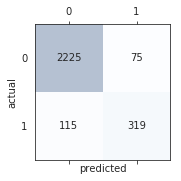

###### Results ######
Model: lda
Mean Training Accuracy: 0.933
Std Training Accuracy: 0.048
Test Accuracy: 0.867
Precision: 0.572
Recall: 0.638
F1 Score: 0.603


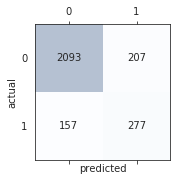

###### Results ######
Model: knn
Mean Training Accuracy: 0.893
Std Training Accuracy: 0.010
Test Accuracy: 0.820
Precision: 0.414
Recall: 0.316
F1 Score: 0.358


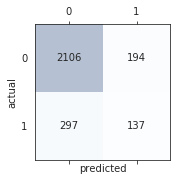

###### Results ######
Model: dtc
Mean Training Accuracy: 0.966
Std Training Accuracy: 0.027
Test Accuracy: 0.885
Precision: 0.679
Recall: 0.521
F1 Score: 0.589


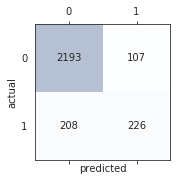

###### Results ######
Model: nbc
Mean Training Accuracy: 0.546
Std Training Accuracy: 0.302
Test Accuracy: 0.333
Precision: 0.173
Recall: 0.850
F1 Score: 0.288


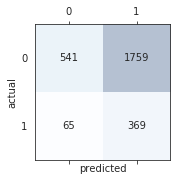

###### Results ######
Model: svm
Mean Training Accuracy: 0.106
Std Training Accuracy: 0.016
Test Accuracy: 0.668
Precision: 0.294
Recall: 0.779
F1 Score: 0.427


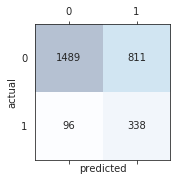

In [33]:
for i in range(len(results["model"])):
    prj.print_ml_results(results, i)

In [33]:
ml_results_df = pd.DataFrame(results)
ml_results_df[["model", "mean_train_acc", "std_train_acc", "test_acc", "precision", "recall", "f1_score"]].sort_values("test_acc", ascending=False)
results_df.to_csv("ml_results.csv")
results_df.to_json("ml_results.json")

,model,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score
0,lgr,0.975917,0.019305,0.930505,0.809645,0.735023,0.770531
3,dtc,0.966167,0.027361,0.884784,0.678679,0.520737,0.589309
1,lda,0.932583,0.047561,0.866862,0.572314,0.638249,0.603486
2,knn,0.892583,0.009534,0.820410,0.413897,0.315668,0.358170
5,svm,0.106083,0.016385,0.668252,0.294169,0.778802,0.427037
4,nbc,0.546000,0.302359,0.332846,0.173402,0.850230,0.288056


### Neural Networks

#### Baseline neural network

In [30]:
num_pixels = X_train.shape[1]
input_dim = X_train.shape[1]
epochs = 10
print("Number of pixels:", num_pixels)
print("Input dim:", input_dim)

Number of pixels: 12100
Input dim: 12100


In [31]:
# Define baseline neural network model
def create_model(num_pixels=num_pixels, input_dim=input_dim, output_dim=1):
    model = Sequential()
    model.add(Dense(units=num_pixels, input_dim=input_dim, kernel_initializer="normal", activation="relu"))
    model.add(Dense(units=output_dim, kernel_initializer="normal", activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [32]:
nn_results = prj.run_nn_model(("nn_model", create_model()), X_train_up, y_train_up, X_test, y_test, epochs=epochs, batch_size=200, validation_split=0.33)

Train on 8039 samples, validate on 3961 samples
Epoch 1/10
8039/8039 [==============================] - 16s 2ms/step - loss: 3.9994 - acc: 0.7391 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
8039/8039 [==============================] - 10s 1ms/step - loss: 4.0885 - acc: 0.7464 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 3/10
8039/8039 [==============================] - 10s 1ms/step - loss: 4.0882 - acc: 0.7464 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/10
8039/8039 [==============================] - 10s 1ms/step - loss: 4.0882 - acc: 0.7464 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 5/10
8039/8039 [==============================] - 10s 1ms/step - loss: 4.0882 - acc: 0.7464 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 6/10
8039/8039 [==============================] - 10s 1ms/step - loss: 4.0882 - acc: 0.7464 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 7/10
8039/8039 [==============================] - 10s 1ms/step - loss: 4.0882 - acc: 0.7464 - val_loss: 16

###### Results ######
Model: nn_model
Training Accuracy: 0.500
Test Accuracy: 0.841
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


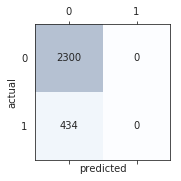

In [33]:
for i in range(len(nn_results["model"])):
    prj.print_nn_results(nn_results, i)

In [34]:
nn_results_df = pd.DataFrame(nn_results)
nn_results_df.to_csv("nn_results.csv")
nn_results_df.to_json("nn_results.json")
nn_results_df[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]]

,model,train_acc,test_acc,precision,recall,f1_score
0,nn_model,0.5,0.841258,0.0,0.0,0.0


#### Convolutional neural networks

In [31]:
# Shape to include channel dim for Conv2D
X_train_up_conv = X_train_up.reshape(X_train_up.shape[0], 1, 110, 110)
X_test_conv = X_test.reshape(X_test.shape[0], 1, 110, 110)

##### CNN model 1

In [32]:
# Set test options 
input_dim = (X_train_up_conv.shape[1], X_train_up_conv.shape[2], X_train_up_conv.shape[3])
epochs = 30
print("Input dim:", input_dim)

Input dim: (1, 110, 110)


In [33]:
# Define cnn model 1
def create_model(input_dim=input_dim, output_dim=1):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=input_dim, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=output_dim, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [37]:
cnn_1_results = prj.run_nn_model(("cnn_1_model", create_model()), X_train_up_conv, y_train_up, X_test_conv, y_test, epochs=epochs, batch_size=200, validation_split=0.05)

Train on 11400 samples, validate on 600 samples
Epoch 1/30
11400/11400 [==============================] - 6s 546us/step - loss: 0.7938 - acc: 0.5179 - val_loss: 0.7344 - val_acc: 0.0000e+00
Epoch 2/30
11400/11400 [==============================] - 5s 482us/step - loss: 0.6697 - acc: 0.5601 - val_loss: 0.7154 - val_acc: 0.2667
Epoch 3/30
11400/11400 [==============================] - 6s 483us/step - loss: 0.6080 - acc: 0.7132 - val_loss: 0.4981 - val_acc: 0.9400
Epoch 4/30
11400/11400 [==============================] - 5s 482us/step - loss: 0.5100 - acc: 0.7753 - val_loss: 0.3582 - val_acc: 0.9333
Epoch 5/30
11400/11400 [==============================] - 5s 482us/step - loss: 0.4142 - acc: 0.8405 - val_loss: 0.1777 - val_acc: 0.9717
Epoch 6/30
11400/11400 [==============================] - 6s 484us/step - loss: 0.3410 - acc: 0.8775 - val_loss: 0.2380 - val_acc: 0.9383
Epoch 7/30
11400/11400 [==============================] - 6s 484us/step - loss: 0.2666 - acc: 0.9124 - val_loss: 0.1849 

###### Results ######
Model: cnn_1_model
Training Accuracy: 1.000
Test Accuracy: 0.949
Precision: 0.904
Recall: 0.760
F1 Score: 0.826


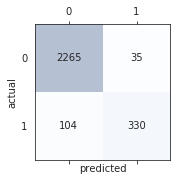

In [38]:
for i in range(len(cnn_1_results["model"])):
    prj.print_nn_results(cnn_1_results, i)

In [39]:
cnn_1_results_df = pd.DataFrame(cnn_1_results)
cnn_1_results_df.to_csv("cnn_1_results.csv")
cnn_1_results_df.to_json("cnn_1_results.json")
cnn_1_results_df[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]]

,model,train_acc,test_acc,precision,recall,f1_score
0,cnn_1_model,1.0,0.949159,0.90411,0.760369,0.826033


##### CNN model 2

In [34]:
# Define model
def create_model(input_dim=input_dim, output_dim=1):
    model = Sequential()
    model.add(Conv2D(filters=30, kernel_size=(5, 5), input_shape=input_dim, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=15, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=50, activation="relu"))
    model.add(Dense(units=output_dim, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [35]:
cnn_2_results = prj.run_nn_model(("cnn_2_model", create_model()), X_train_up_conv, y_train_up, X_test_conv, y_test, epochs=epochs, batch_size=200, validation_split=0.05)

Train on 11400 samples, validate on 600 samples
Epoch 1/30
11400/11400 [==============================] - 6s 549us/step - loss: 0.6887 - acc: 0.5280 - val_loss: 0.6992 - val_acc: 0.2000
Epoch 2/30
11400/11400 [==============================] - 5s 426us/step - loss: 0.6483 - acc: 0.6064 - val_loss: 0.8347 - val_acc: 0.2667
Epoch 3/30
11400/11400 [==============================] - 5s 424us/step - loss: 0.4731 - acc: 0.7968 - val_loss: 0.3844 - val_acc: 0.8550
Epoch 4/30
11400/11400 [==============================] - 5s 425us/step - loss: 0.3055 - acc: 0.8878 - val_loss: 0.2915 - val_acc: 0.8817
Epoch 5/30
11400/11400 [==============================] - 5s 424us/step - loss: 0.2189 - acc: 0.9182 - val_loss: 0.2096 - val_acc: 0.9133
Epoch 6/30
11400/11400 [==============================] - 5s 424us/step - loss: 0.1859 - acc: 0.9318 - val_loss: 0.1347 - val_acc: 0.9617
Epoch 7/30
11400/11400 [==============================] - 5s 425us/step - loss: 0.1595 - acc: 0.9447 - val_loss: 0.1336 - va

###### Results ######
Model: cnn_2_model
Training Accuracy: 1.000
Test Accuracy: 0.959
Precision: 0.892
Recall: 0.841
F1 Score: 0.866


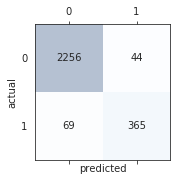

In [36]:
for i in range(len(cnn_2_results["model"])):
    prj.print_nn_results(cnn_2_results, i)

In [37]:
cnn_2_results_df = pd.DataFrame(cnn_2_results)
cnn_2_results_df.to_csv("cnn_2_results.csv")
cnn_2_results_df.to_json("cnn_2_results.json")
cnn_2_results_df[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]]

,model,train_acc,test_acc,precision,recall,f1_score
0,cnn_2_model,0.999833,0.958669,0.892421,0.841014,0.865955


##### CNN model 3

In [34]:
def create_model(input_dim=input_dim, output_dim=1, epochs=epochs, lrate=0.01):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_dim, padding="same", activation="relu",
                    kernel_constraint=maxnorm(3)))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",
                     kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation="sigmoid"))

    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

In [35]:
cnn_3_results = prj.run_nn_model(("cnn_3_model", create_model()), X_train_up_conv, y_train_up, X_test_conv, y_test, epochs=epochs, batch_size=200, validation_split=0.05)

Train on 11400 samples, validate on 600 samples
Epoch 1/30
11400/11400 [==============================] - 20s 2ms/step - loss: 0.6932 - acc: 0.5269 - val_loss: 0.7144 - val_acc: 0.0000e+00
Epoch 2/30
11400/11400 [==============================] - 17s 2ms/step - loss: 0.6809 - acc: 0.5722 - val_loss: 0.6415 - val_acc: 0.9867
Epoch 3/30
11400/11400 [==============================] - 17s 2ms/step - loss: 0.5749 - acc: 0.7364 - val_loss: 0.3110 - val_acc: 0.9250
Epoch 4/30
11400/11400 [==============================] - 17s 2ms/step - loss: 0.3956 - acc: 0.8379 - val_loss: 0.2900 - val_acc: 0.8950
Epoch 5/30
11400/11400 [==============================] - 17s 2ms/step - loss: 0.3312 - acc: 0.8682 - val_loss: 0.3951 - val_acc: 0.8100
Epoch 6/30
11400/11400 [==============================] - 17s 2ms/step - loss: 0.2979 - acc: 0.8818 - val_loss: 0.1947 - val_acc: 0.9300
Epoch 7/30
11400/11400 [==============================] - 17s 2ms/step - loss: 0.2739 - acc: 0.8904 - val_loss: 0.2294 - val_a

###### Results ######
Model: cnn_3_model
Training Accuracy: 0.997
Test Accuracy: 0.956
Precision: 0.870
Recall: 0.850
F1 Score: 0.860


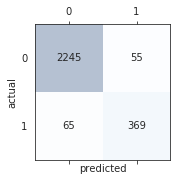

In [36]:
for i in range(len(cnn_3_results["model"])):
    prj.print_nn_results(cnn_3_results, i)

In [37]:
cnn_3_results_df = pd.DataFrame(cnn_3_results)
cnn_3_results_df.to_csv("cnn_3_results.csv")
cnn_3_results_df.to_json("cnn_3_results.json")
cnn_3_results_df[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]]

,model,train_acc,test_acc,precision,recall,f1_score
0,cnn_3_model,0.996917,0.956108,0.870283,0.85023,0.86014


##### CNN model 4

In [34]:
def create_model(input_dim=input_dim, output_dim=1, epochs=epochs, lrate=0.01):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_dim, padding="same", activation="relu"))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same",))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same",))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(1024, activation="relu", kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation="relu", kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation="sigmoid"))

    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

In [35]:
cnn_4_results = prj.run_nn_model(("cnn_4_model", create_model()), X_train_up_conv, y_train_up, X_test_conv, y_test, epochs=epochs, batch_size=200, validation_split=0.05)

Train on 11400 samples, validate on 600 samples
Epoch 1/30
11400/11400 [==============================] - 33s 3ms/step - loss: 0.6918 - acc: 0.5221 - val_loss: 0.7147 - val_acc: 0.0000e+00
Epoch 2/30
11400/11400 [==============================] - 29s 3ms/step - loss: 0.6904 - acc: 0.5277 - val_loss: 0.7338 - val_acc: 0.0000e+00
Epoch 3/30
11400/11400 [==============================] - 29s 3ms/step - loss: 0.6866 - acc: 0.5403 - val_loss: 0.6962 - val_acc: 0.3383
Epoch 4/30
11400/11400 [==============================] - 29s 3ms/step - loss: 0.6486 - acc: 0.6532 - val_loss: 0.6154 - val_acc: 0.6067
Epoch 5/30
11400/11400 [==============================] - 29s 3ms/step - loss: 0.5196 - acc: 0.7789 - val_loss: 0.3948 - val_acc: 0.8100
Epoch 6/30
11400/11400 [==============================] - 29s 3ms/step - loss: 0.4093 - acc: 0.8370 - val_loss: 0.3794 - val_acc: 0.8083
Epoch 7/30
11400/11400 [==============================] - 29s 3ms/step - loss: 0.2908 - acc: 0.8861 - val_loss: 0.2293 - v

###### Results ######
Model: cnn_4_model
Training Accuracy: 0.999
Test Accuracy: 0.971
Precision: 0.916
Recall: 0.901
F1 Score: 0.908


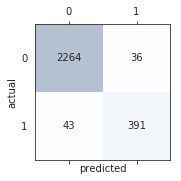

In [36]:
for i in range(len(cnn_4_results["model"])):
    prj.print_nn_results(cnn_4_results, i)

In [37]:
cnn_4_results_df = pd.DataFrame(cnn_4_results)
cnn_4_results_df.to_csv("cnn_4_results.csv")
cnn_4_results_df.to_json("cnn_4_results.json")
cnn_4_results_df[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]]

,model,train_acc,test_acc,precision,recall,f1_score
0,cnn_4_model,0.998583,0.971105,0.915691,0.900922,0.908246


### Compare Algorithms

In [37]:
ml_results_df = pd.read_json("ml_results.json")
nn_results_df = pd.read_json("nn_results.json")
cnn_1_results_df = pd.read_json("cnn_1_results.json")
cnn_2_results_df = pd.read_json("cnn_2_results.json")
cnn_3_results_df = pd.read_json("cnn_3_results.json")
cnn_4_results_df = pd.read_json("cnn_4_results.json")

In [38]:
ml_results_df[["model", "mean_train_acc", "std_train_acc", "test_acc", "precision", "recall", "f1_score"]].sort_values("test_acc", ascending=False)

,model,mean_train_acc,std_train_acc,test_acc,precision,recall,f1_score
0,lgr,0.975917,0.019305,0.930505,0.809645,0.735023,0.770531
3,dtc,0.966167,0.027361,0.884784,0.678679,0.520737,0.589309
1,lda,0.932583,0.047561,0.866862,0.572314,0.638249,0.603486
2,knn,0.892583,0.009534,0.820410,0.413897,0.315668,0.358170
5,svm,0.106083,0.016385,0.668252,0.294169,0.778802,0.427037
4,nbc,0.546000,0.302359,0.332846,0.173402,0.850230,0.288056


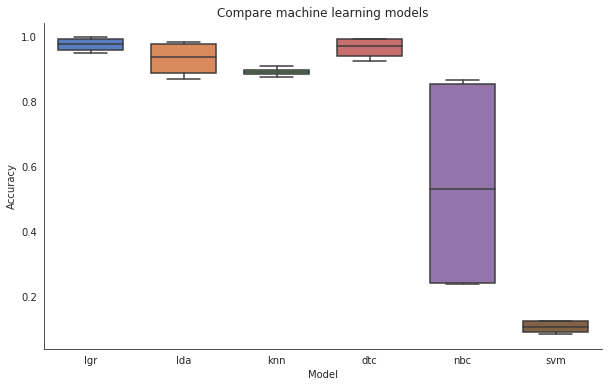

In [39]:
model_names = list(ml_results_df["model"])
cv_results = list(ml_results_df["full_cv_results"])

fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot(x=model_names, y=cv_results, width=0.7)
ax.set_title("Compare machine learning models")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
sns.despine()
plt.show()

In [40]:
full_nn_results = pd.concat([nn_results_df,cnn_1_results_df, cnn_2_results_df, cnn_3_results_df, cnn_4_results_df])
full_nn_results[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]].sort_values("test_acc", ascending=False)

,model,train_acc,test_acc,precision,recall,f1_score
0,cnn_4_model,0.998583,0.971105,0.915691,0.900922,0.908246
0,cnn_2_model,0.999833,0.958669,0.892421,0.841014,0.865955
0,cnn_3_model,0.996917,0.956108,0.870283,0.850230,0.860140
0,cnn_1_model,1.000000,0.949159,0.904110,0.760369,0.826033
0,nn_model,0.500000,0.841258,0.000000,0.000000,0.000000


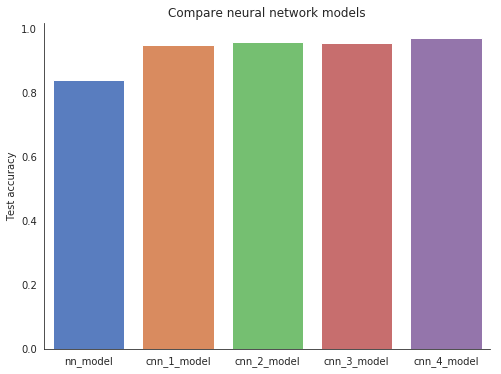

In [41]:
fig = plt.figure(figsize=(8, 6))
ax = sns.barplot(x="model", y="test_acc", data=full_nn_results)
ax.set_title("Compare neural network models")
ax.set_ylabel("Test accuracy")
ax.set_xlabel("")
sns.despine()
plt.show()

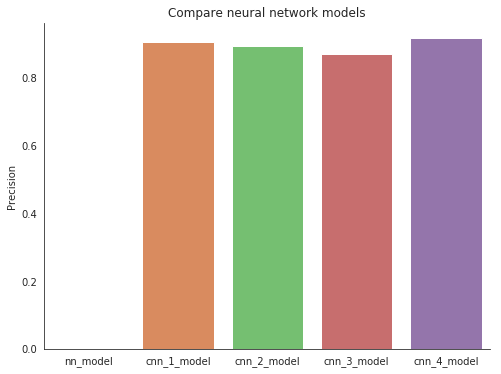

In [42]:
fig = plt.figure(figsize=(8, 6))
ax = sns.barplot(x="model", y="precision", data=full_nn_results)
ax.set_title("Compare neural network models")
ax.set_ylabel("Precision")
ax.set_xlabel("")
sns.despine()
plt.show()

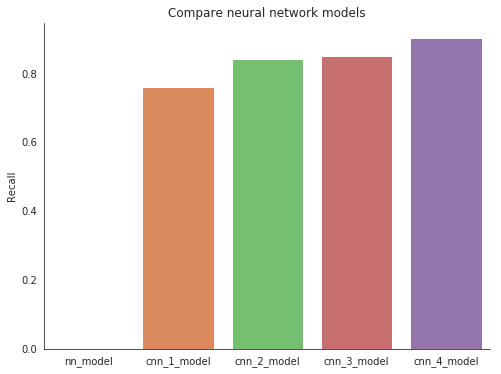

In [43]:
fig = plt.figure(figsize=(8, 6))
ax = sns.barplot(x="model", y="recall", data=full_nn_results)
ax.set_title("Compare neural network models")
ax.set_ylabel("Recall")
ax.set_xlabel("")
sns.despine()
plt.show()

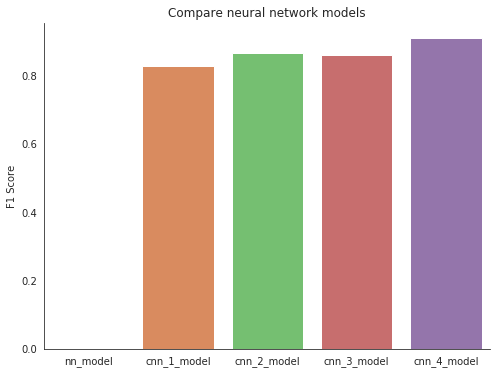

In [44]:
fig = plt.figure(figsize=(8, 6))
ax = sns.barplot(x="model", y="f1_score", data=full_nn_results)
ax.set_title("Compare neural network models")
ax.set_ylabel("F1 Score")
ax.set_xlabel("")
sns.despine()
plt.show()

## Improve top algorithms

### Tuning top machine learning model

In [33]:
# Restore data shape for machine learning models
X_upsampled, y_upsampled = resample(X_train[y_train == 1], y_train[y_train == 1], replace=True,
                                   n_samples=X_train[y_train == 0].shape[0], random_state=seed)

X_train_up = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_up = np.hstack((y_train[y_train == 0], y_upsampled))

y_pred = np.zeros(y_train_up.shape[0])
print("New class distribution:", np.mean(y_pred == y_train_up))

print("X_train_up shape:", X_train_up.shape)
print("y_train_up shape:", y_train_up.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

New class distribution: 0.5
X_train_up shape: (12000, 12100)
y_train_up shape: (12000,)
X_test shape: (2734, 12100)
y_test shape: (2734,)


In [36]:
penalties = ["l1", "l2"]
cees = [0.1, 1.0, 10]
param_grid = dict(penalty=penalties, C=cees)

In [37]:
lgr = LogisticRegression()
grid = GridSearchCV(estimator=lgr, param_grid=param_grid, cv=3, verbose=3)
grid_results = grid.fit(X_train_up, y_train_up)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................. C=0.1, penalty=l1, score=0.88675, total=  13.9s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


[CV] ................... C=0.1, penalty=l1, score=0.885, total=  15.1s
[CV] C=0.1, penalty=l1 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.2s remaining:    0.0s


[CV] ................. C=0.1, penalty=l1, score=0.89225, total=  14.5s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................. C=0.1, penalty=l2, score=0.95325, total=  29.9s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................. C=0.1, penalty=l2, score=0.95675, total=  27.9s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................. C=0.1, penalty=l2, score=0.96125, total=  29.1s
[CV] C=1.0, penalty=l1 ...............................................
[CV] .................. C=1.0, penalty=l1, score=0.9635, total= 1.2min
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................. C=1.0, penalty=l1, score=0.96425, total= 1.8min
[CV] C=1.0, penalty=l1 ...............................................
[CV] .................. C=1.0, penalty=l1, score=0.9615, total= 1.3min
[CV] C=1.0, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.7min finished


In [38]:
means = grid_results.cv_results_["mean_test_score"]
stds = grid_results.cv_results_["std_test_score"]
params = grid_results.cv_results_["params"]

print("Best: {:.4f} using {}\n".format(grid_results.best_score_, grid_results.best_params_))
for mean, stdev, param in zip(means, stds, params):
    print("{:.4f} +/- {:.2f} with: {}".format(mean, stdev, param))

Best: 0.9758 using {'C': 1.0, 'penalty': 'l2'}

0.8880 +/- 0.00 with: {'C': 0.1, 'penalty': 'l1'}
0.9571 +/- 0.00 with: {'C': 0.1, 'penalty': 'l2'}
0.9631 +/- 0.00 with: {'C': 1.0, 'penalty': 'l1'}
0.9758 +/- 0.00 with: {'C': 1.0, 'penalty': 'l2'}
0.9704 +/- 0.00 with: {'C': 10, 'penalty': 'l1'}
0.9758 +/- 0.00 with: {'C': 10, 'penalty': 'l2'}


The best model uses the same hyperparameters as the sklearn's logistic regression defaults.

### Tuning top neural network model

In [42]:
# Shape to include channel dim for Conv2D
X_train_up_conv = X_train_up.reshape(X_train_up.shape[0], 1, 110, 110)
X_test_conv = X_test.reshape(X_test.shape[0], 1, 110, 110)

In [35]:
# Set test options 
input_dim = (X_train_up_conv.shape[1], X_train_up_conv.shape[2], X_train_up_conv.shape[3])
epochs = 30
print("Input dim:", input_dim)

Input dim: (1, 110, 110)


In [36]:
def create_model(input_dim=input_dim, output_dim=1, epochs=epochs, lrate=0.01, activation="relu"):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_dim, padding="same", activation=activation))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(1024, activation=activation, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation=activation, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation="sigmoid"))

    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

In [38]:
learn_rates = [0.001, 0.01, 0.1, 0.3]
activations = ["relu", "linear"]
param_grid = dict(lrate=learn_rates, activation=activations)

In [39]:
cnn_4 = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=200, verbose=0)

In [43]:
grid = GridSearchCV(estimator=cnn_4, param_grid=param_grid, cv=3, verbose=3)
grid_results = grid.fit(X_train_up_conv, y_train_up)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] activation=relu, lrate=0.001 ....................................
[CV] .......... activation=relu, lrate=0.001, score=0.0, total= 2.0min
[CV] activation=relu, lrate=0.001 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV]  activation=relu, lrate=0.001, score=0.5205000001937151, total= 1.8min
[CV] activation=relu, lrate=0.001 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV] .......... activation=relu, lrate=0.001, score=0.0, total= 1.9min
[CV] activation=relu, lrate=0.01 .....................................
[CV]  activation=relu, lrate=0.01, score=0.8644999980926513, total= 1.8min
[CV] activation=relu, lrate=0.01 .....................................
[CV]  activation=relu, lrate=0.01, score=0.9764999985694885, total= 1.8min
[CV] activation=relu, lrate=0.01 .....................................
[CV]  activation=relu, lrate=0.01, score=0.9605000048875809, total= 1.9min
[CV] activation=relu, lrate=0.1 ......................................
[CV] ............ activation=relu, lrate=0.1, score=0.0, total= 1.9min
[CV] activation=relu, lrate=0.1 ......................................
[CV] ............ activation=relu, lrate=0.1, score=0.5, total= 1.9min
[CV] activation=relu, lrate=0.1 ......................................
[CV] ............ activation=relu, lrate=0.1, score=0.0, total= 1.8min
[CV] activation=relu, lrate=0.3 .................................

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 43.8min finished


In [44]:
means = grid_results.cv_results_["mean_test_score"]
stds = grid_results.cv_results_["std_test_score"]
params = grid_results.cv_results_["params"]

print("Best: {:.4f} using {}\n".format(grid_results.best_score_, grid_results.best_params_))
for mean, stdev, param in zip(means, stds, params):
    print("{:.4f} +/- {:.2f} with: {}".format(mean, stdev, param))

Best: 0.9669 using {'activation': 'linear', 'lrate': 0.01}

0.1735 +/- 0.25 with: {'activation': 'relu', 'lrate': 0.001}
0.9338 +/- 0.05 with: {'activation': 'relu', 'lrate': 0.01}
0.1667 +/- 0.24 with: {'activation': 'relu', 'lrate': 0.1}
0.1667 +/- 0.24 with: {'activation': 'relu', 'lrate': 0.3}
0.7277 +/- 0.24 with: {'activation': 'linear', 'lrate': 0.001}
0.9669 +/- 0.02 with: {'activation': 'linear', 'lrate': 0.01}
0.5000 +/- 0.41 with: {'activation': 'linear', 'lrate': 0.1}
0.5000 +/- 0.41 with: {'activation': 'linear', 'lrate': 0.3}


## Finalize model
### Train finalized model on the entire training dataset

In [33]:
# Set test options 
input_dim = (X_train_up_conv.shape[1], X_train_up_conv.shape[2], X_train_up_conv.shape[3])
epochs = 30
print("Input dim:", input_dim)

Input dim: (1, 110, 110)


In [34]:
def create_model(input_dim=input_dim, output_dim=1, epochs=epochs, lrate=0.01, activation="relu"):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_dim, padding="same", activation=activation))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same",))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(1024, activation=activation, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation=activation, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation="sigmoid"))

    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

In [35]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 110, 110)      320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 110, 110)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 110, 110)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 55, 55)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 55, 55)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 55, 55)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 55, 55)        36928     
__________

In [36]:
model.fit(X_train_up_conv, y_train_up, epochs=epochs, batch_size=200, verbose=1)

Epoch 1/30
12000/12000 [==============================] - 34s 3ms/step - loss: 0.6932 - acc: 0.5086
Epoch 2/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.6916 - acc: 0.5295
Epoch 3/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.6856 - acc: 0.5577
Epoch 4/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.6145 - acc: 0.6848
Epoch 5/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.4705 - acc: 0.8063
Epoch 6/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.3028 - acc: 0.8842
Epoch 7/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.2430 - acc: 0.9102
Epoch 8/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.2111 - acc: 0.9200
Epoch 9/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.1889 - acc: 0.9291
Epoch 10/30
12000/12000 [==============================] - 30s 3ms/step - loss: 0.1584 - acc: 0.9430

In [37]:
scores = model.evaluate(X_test_conv, y_test, verbose=0)
print("Baseline accuracy: {:.4f}%".format(scores[1]))

Baseline accuracy: 0.9755%


### Run predictions on testing dataset

In [65]:
scores = model.evaluate(X_train_up_conv, y_train_up, verbose=0)
preds = model.predict_classes(X_test_conv)

In [66]:
final_results_dict = dict(model=["cnn_4"],
                          train_acc=[scores[1]],
                          test_acc=[accuracy_score(y_test, preds)],
                          precision=[precision_score(y_test, preds)],
                          recall=[recall_score(y_test, preds)],
                          f1_score=[f1_score(y_test, preds)],
                          confusion_matrix=[confusion_matrix(y_test, preds)],
                          classification_report=[classification_report(y_test, preds)]
                         )


final_results_df = pd.DataFrame(data=final_results_dict)
final_results_df.to_csv("final_results.csv")
final_results_df.to_json("final_results.json")
final_results_df[["model", "train_acc", "test_acc", "precision", "recall", "f1_score"]]

,model,train_acc,test_acc,precision,recall,f1_score
0,cnn_4,0.999667,0.975494,0.929742,0.914747,0.922184


###### Results ######
Model: cnn_4
Training Accuracy: 1.000
Test Accuracy: 0.975
Precision: 0.930
Recall: 0.915
F1 Score: 0.922


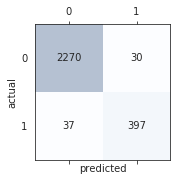

In [67]:
prj.print_nn_results(final_results_df, 0)

### Save model

In [68]:
# Serialize model to JSON
final_model_json = model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(final_model_json)

# Serialize weights to HDF5
model.save_weights("final_model.h5")
print("Saved model to disk.")

Saved model to disk.
